In [171]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy

from scipy import signal
from matplotlib import cm

In [172]:
cat_directory = './data/lunar/test/data/S12_GradeB/'
file = 'xa.s12.00.mhz.1974-07-25HR05_evid00553'
cat_file = cat_directory + file + '.csv'
cat = pd.read_csv(cat_file)

In [173]:
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

# Let's also get the name of the file
test_filename = file
test_filename

'xa.s12.00.mhz.1974-07-25HR05_evid00553'

In [174]:
data_directory = cat_directory
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)

In [175]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

0.90566

In [176]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1

# Going to create a separate trace for the filter data
st_filt = st.copy()
# st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [177]:
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

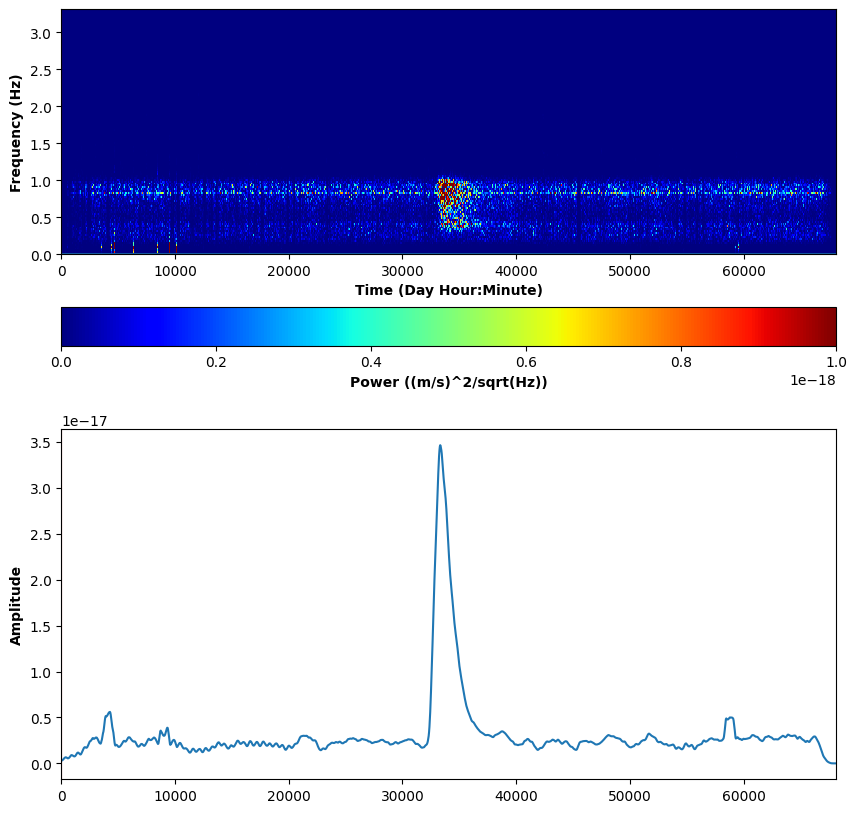

In [178]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 1)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=1e-18)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_ylim([0, max(f)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

newsxx = np.transpose(sxx)

smth_rng = 5
for i in range(len(newsxx)):
    for j in range(len(newsxx[i])):
        for k in range(smth_rng):
            if i+k < len(newsxx):
                newsxx[i][j] += newsxx[i+k][j]
        newsxx[i][j] = newsxx[i][j]/smth_rng

ampl = []
for i in range(len(newsxx)):
    ampl.append(np.sum(newsxx[i]))

# smothing
ampl = signal.savgol_filter(ampl, 5, 2)
for i in range(len(ampl)):
    amp = 0
    for j in range(25):
        if i+j < len(ampl):
            amp += ampl[i+j]
    ampl[i] = amp/25



ax3 = plt.subplot(2, 1, 2)
ax3.plot(t, ampl)
ax3.axvline(x=arrival, c='red')
ax3.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax3.set_ylabel('Amplitude', fontweight='bold')

plt.show()

In [179]:
def calc_local_avreage(avr_window, pos, ampl):
    _avr = 0
    avr_window_adj = avr_window
    for j in range(pos - int(avr_window/2), pos + int(avr_window/2)):
        if j < 0 or j >= len(ampl):
            avr_window_adj -= 1
            continue
        _avr += ampl[j]
    _avr /= avr_window_adj
    return _avr
    

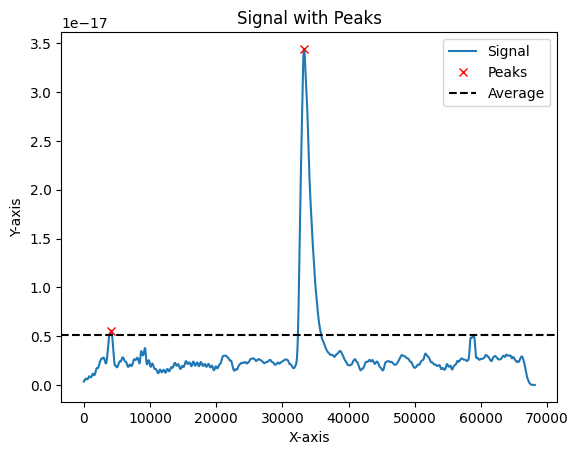

[123, 984]

In [180]:
avr_window = 1000

# smoth the peaks
ampl = signal.savgol_filter(ampl, 5, 2)
for i in range(len(ampl)):
    amp = 0
    for j in range(5):
        if i+j < len(ampl):
            amp += ampl[i+j]
    ampl[i] = amp/5

# Find peaks
peaks, _ = scipy.signal.find_peaks(ampl, distance=33)  # You can adjust parameters as needed


_peaks = []
for i in range(len(peaks)):
    # claculate the local average of the peak
    avr = 0
    avr = calc_local_avreage(avr_window, peaks[i], ampl)

    if ampl[peaks[i]] > avr:
        _peaks.append(peaks[i])
peaks = _peaks

avr = 0

for i in peaks:
    avr += ampl[i]
avr = avr / len(peaks)

_peaks = []
for i in range(len(peaks)):
    if ampl[peaks[i]] > avr:
        _peaks.append(peaks[i])
peaks = _peaks

# Plot the signal and the peaks
plt.plot(t, ampl, label='Signal')
plt.plot(t[peaks], ampl[peaks], "x", label='Peaks', color='red')
plt.title('Signal with Peaks')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(y=avr, color='black', linestyle='--', label='Average')
plt.legend()
plt.show()

peaks

1010 959 2.0014395659975598e-17 7.89067273758705e-18 984 3.442979045042421e-17


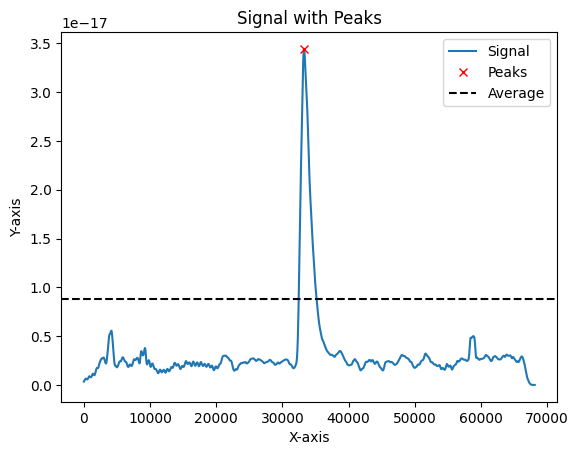

[984]

In [181]:
import math
_peaks = []
newPeaks=[]
for peak in peaks:
    if ampl[peak] > ampl[peak-20] and ampl[peak] > ampl[peak+20]:
        _peaks.append(peak)

#print(peak, _peaks.index(peak), _peaks)
minAvg = peak
maxAvg = peak
avr_window = int(np.log(ampl[peak] * 8e19)*33)
avr = calc_local_avreage(avr_window, peak, ampl)
while ampl[minAvg] > avr and minAvg > 0 and minAvg - maxAvg <= 50:
    minAvg -= 1
while ampl[maxAvg] > avr and maxAvg < 2554 and maxAvg - minAvg <= 50:
    maxAvg += 1
if maxAvg - minAvg > 50:
    print(maxAvg, minAvg, ampl[maxAvg], ampl[minAvg], peak, ampl[peak])
    newPeaks.append(peak)


plt.plot(t, ampl, label='Signal')
plt.plot(t[newPeaks], ampl[newPeaks], "x", label='Peaks', color='red')
plt.title('Signal with Peaks')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(y=avr, color='black', linestyle='--', label='Average')
plt.legend()
plt.show()

newPeaks


Text(0.5, 1.0, 'xa.s12.00.mhz.1974-07-25HR05_evid00553')

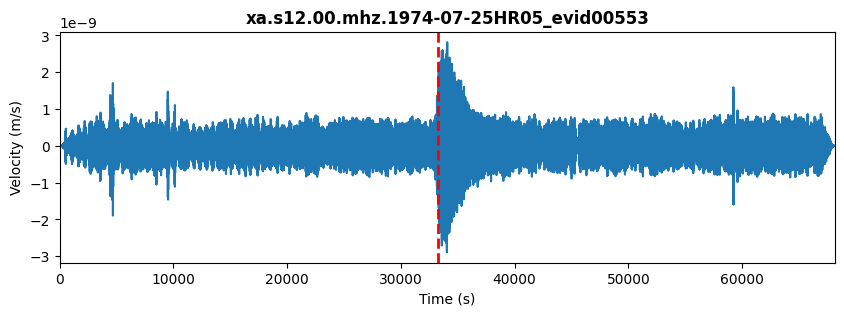

In [182]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
for pos in t[newPeaks]:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=2)

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')
